In [12]:
import argparse

import os
import sys
import json
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

PAD_TOKEN = '_PAD_'
UNK_TOKEN = '_UNK_'

mydir = '/Users/mlx/Documents/SpringSemester/DataScience/assignment4'
criterion = nn.CrossEntropyLoss()

In [3]:
# Methods for loading SST data

def sentiment2label(x):
    if x >= 0 and x <= 0.2:
        return 0
    elif x > 0.2 and x <= 0.4:
        return 1
    elif x > 0.4 and x <= 0.6:
        return 2
    elif x > 0.6 and x <= 0.8:
        return 3
    elif x > 0.8 and x <= 1:
        return 4
    else:
        raise ValueError('Improper sentiment value {}'.format(x))


def read_dictionary_txt_with_phrase_ids(dictionary_path, phrase_ids_path, labels_path=None):
    print('Reading data dictionary_path={} phrase_ids_path={} labels_path={}'.format(
        dictionary_path, phrase_ids_path, labels_path))

    with open(phrase_ids_path) as f:
        phrase_ids = set(line.strip() for line in f)

    with open(dictionary_path) as f:
        examples_dict = dict()
        for line in f:
            parts = line.strip().split('|')
            phrase = parts[0]
            phrase_id = parts[1]

            if phrase_id not in phrase_ids:
                continue

            example = dict()
            example['phrase'] = phrase.replace('(', '-LRB').replace(')', '-RRB-')
            example['tokens'] = example['phrase'].split(' ')
            example['example_id'] = phrase_id
            example['label'] = None
            examples_dict[example['example_id']] = example

    if labels_path is not None:
        with open(labels_path) as f:
            for i, line in enumerate(f):
                if i == 0:
                    continue
                parts = line.strip().split('|')
                phrase_id = parts[0]
                sentiment = float(parts[1])
                label = sentiment2label(sentiment)

                if phrase_id in examples_dict:
                    examples_dict[phrase_id]['label'] = label

    examples = [ex for _, ex in examples_dict.items()]

    print('Found {} examples.'.format(len(examples)))

    return examples


def build_vocab(datasets):
    vocab = dict()
    vocab[PAD_TOKEN] = len(vocab)
    vocab[UNK_TOKEN] = len(vocab)
    for data in datasets:
        for example in data:
            for word in example['tokens']:
                if word not in vocab:
                    vocab[word] = len(vocab)

    print('Vocab size: {}'.format(len(vocab)))

    return vocab


class TokenConverter(object):
    def __init__(self, vocab):
        self.vocab = vocab
        self.unknown = 0

    def convert(self, token):
        if token in self.vocab:
            id = self.vocab.get(token)
        else:
            id = self.vocab.get(UNK_TOKEN)
            self.unknown += 1
        return id


def convert2ids(data, vocab):
    converter = TokenConverter(vocab)
    for example in data:
        example['tokens'] = list(map(converter.convert, example['tokens']))
    print('Found {} unknown tokens.'.format(converter.unknown))
    return data


def load_data_and_embeddings(data_path, phrase_ids_path, embeddings_path):
    labels_path = os.path.join(data_path, 'sentiment_labels.txt')
    dictionary_path = os.path.join(data_path, 'dictionary.txt')
    train_data = read_dictionary_txt_with_phrase_ids(dictionary_path,
                                                     os.path.join(phrase_ids_path, 'phrase_ids.train.txt'), labels_path)
    validation_data = read_dictionary_txt_with_phrase_ids(dictionary_path,
                                                          os.path.join(phrase_ids_path, 'phrase_ids.dev.txt'),
                                                          labels_path)
    test_data = read_dictionary_txt_with_phrase_ids(dictionary_path,
                                                    os.path.join(phrase_ids_path, 'phrase_ids.test.txt'),
                                                    labels_path)
    vocab = build_vocab([train_data, validation_data, test_data])
    vocab, embeddings = load_embeddings(embeddings_path, vocab, cache=True)
    train_data = convert2ids(train_data, vocab)
    validation_data = convert2ids(validation_data, vocab)
    test_data = convert2ids(test_data, vocab)
    return train_data, validation_data, test_data, vocab, embeddings


def load_embeddings(path, vocab, cache=False, cache_path=None):
    rows = []
    new_vocab = [UNK_TOKEN]

    if cache_path is None:
        cache_path = path + '.cache'

    # Use cache file if it exists.
    if os.path.exists(cache_path):
        path = cache_path

    print("Reading embeddings from {}".format(path))

    # first pass over the embeddings to vocab and relevant rows
    with open(path) as f:
        for line in f:
            word, row = line.split(' ', 1)
            if word == UNK_TOKEN:
                raise ValueError('The unk token should not exist w.in embeddings.')
            if word in vocab:
                rows.append(line)
                new_vocab.append(word)

    # optionally save relevant rows to cache file.
    if cache and not os.path.exists(cache_path):
        with open(cache_path, 'w') as f:
            for line in rows:
                f.write(line)
            print("Cached embeddings to {}".format(cache_path))

    # turn vocab list into a dictionary
    new_vocab = {w: i for i, w in enumerate(new_vocab)}

    print('New vocab size: {}'.format(len(new_vocab)))

    assert len(rows) == len(new_vocab) - 1

    # create embeddings matrix
    embeddings = np.zeros((len(new_vocab), 300), dtype=np.float32)
    for i, line in enumerate(rows):
        embeddings[i + 1] = list(map(float, line.strip().split(' ')[1:]))

    return new_vocab, embeddings


# Batch Iterator

def prepare_data(data):
    # pad data
    maxlen = max(map(len, data))
    data = [ex + [0] * (maxlen - len(ex)) for ex in data]

    # wrap in tensor
    return torch.LongTensor(data)


def prepare_labels(labels):
    try:
        return torch.LongTensor(labels)
    except:
        return labels


def batch_iterator(dataset, batch_size, forever=False):
    dataset_size = len(dataset)
    order = None
    nbatches = dataset_size // batch_size

    def init_order():
        return random.sample(range(dataset_size), dataset_size)

    def get_batch(start, end):
        batch = [dataset[ii] for ii in order[start:end]]
        data = prepare_data([ex['tokens'] for ex in batch])
        labels = prepare_labels([ex['label'] for ex in batch])
        example_ids = [ex['example_id'] for ex in batch]
        return data, labels, example_ids

    order = init_order()

    while True:
        for i in range(nbatches):
            start = i * batch_size
            end = (i + 1) * batch_size
            yield get_batch(start, end)

        if nbatches * batch_size < dataset_size:
            yield get_batch(nbatches * batch_size, dataset_size)

        if not forever:
            break

        order = init_order()


In [4]:
# Utility Methods

def checkpoint_model(step, val_acc, model, opt, save_path):
    save_dict = dict(
        step=step,
        val_acc=val_acc,
        model_state_dict=model.state_dict(),
        opt_state_dict=opt.state_dict())
    torch.save(save_dict, save_path)


def load_model(model, opt, load_path):
    load_dict = torch.load(load_path)
    step = load_dict['step']
    val_acc = load_dict['val_acc']
    model.load_state_dict(load_dict['model_state_dict'])
    opt.load_state_dict(load_dict['opt_state_dict'])
    return step, val_acc

In [5]:
def run_validation(model, dataset, options):
    class_correct = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    class_count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

    correct = 0
    count = 0
    for data, labels, _ in batch_iterator(dataset, options.batch_size, forever=False):
        outp = model(Variable(data))
        loss = criterion(F.log_softmax(outp), Variable(labels))
        correct += (outp.data.max(1)[1] == labels).sum()
        for label in labels:
            class_count[label] += 1
        count += data.shape[0]
    print('each class count: {}'.format(class_count))
    acc = correct / float(count)
    print('Ev-Loss={}, Ev-Acc={}'.format(loss.data[0], acc))
    return acc

In [6]:
def run_test(model, dataset, options):
    print('Writing predictions to {}'.format(os.path.abspath(options.predictions)))

    preds_dict = dict()

    correct = 0
    count = 0

    for data, labels, example_ids in batch_iterator(dataset, options.batch_size, forever=False):
        outp = model(Variable(data))
        loss = criterion(F.log_softmax(outp), Variable(labels))
        correct += (outp.data.max(1)[1] == labels).sum()
        count += data.shape[0]
        preds = outp.data.max(1)[1]
        for id, pred in zip(example_ids, preds):
            preds_dict[id] = pred

    acc = correct / float(count)
    print('Test-Loss={}, Test-Acc={}'.format(loss.data[0], acc))
    with open(options.predictions, 'w') as f:
        for id, pred in preds_dict.items():
            f.write('{}|{}\n'.format(id, pred))


In [7]:
def run(options):
    max_steps = options.max_steps
    train_data, validation_data, test_data, vocab, embeddings = \
        load_data_and_embeddings(options.data, options.ids, options.embeddings)

    model = models.CNNClassifier(embeddings, 5, is_static=True)
    opt = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

    step = 0
    best_val_acc = 0.0

    if options.eval_only_mode:
        step, best_val_acc = load_model(model, opt, options.model)
        print('Model loaded from {}\nstep={} best_val_acc={}'.format(options.model, step, best_val_acc))
        run_test(model, test_data, options)
        sys.exit()

    for data, labels, _ in batch_iterator(train_data, options.batch_size, forever=True):
        if step > max_steps:
            sys.exit()
        outp = model(Variable(data))
        loss = criterion(F.log_softmax(outp), Variable(labels))
        acc = (outp.data.max(1)[1] == labels).sum() / data.shape[0]

        opt.zero_grad()
        loss.backward()
        opt.step()

        if step % options.log_every == 0:
            print('Step={} Tr-Loss={} Tr-Acc={}'.format(step, loss.data[0], acc))

        if step % options.eval_every == 0:
            val_acc = run_validation(model, validation_data, options)

            # early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                print('Checkpointing model step={} best_val_acc={}.'.format(step, best_val_acc))
                checkpoint_model(step, val_acc, model, opt, options.model)

        step += 1


In [9]:
class CNNClassifier(nn.Module):
    def __init__(self, embeddings, output_size, in_channel=1, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5,
                 is_static=False):
        super(CNNClassifier, self).__init__()
        self.embed = nn.Embedding(embeddings.shape[0], embeddings.shape[1], sparse=True)
        self.embed.weight.data.copy_(torch.from_numpy(embeddings).float())
        if is_static:
            self.embed.weight.requires_grad = False
        self.convs = nn.ModuleList([nn.Conv2d(in_channel, kernel_dim, (K, embeddings.shape[1])) for K in kernel_sizes])

        # kernal_size = (K,D)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)

    def forward(self, inputs):
        inputs = self.embed(inputs).unsqueeze(1)  # (B,1,T,D)
        inputs = [F.relu(conv(inputs)).squeeze(3) for conv in self.convs]  # [(N,Co,W), ...]*len(Ks)
        inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs]  # [(N,Co), ...]*len(Ks)

        concated = torch.cat(inputs, 1)

        if self.training:
            concated = self.dropout(concated)  # (N,len(Ks)*Co)
        out = self.fc(concated)
        return F.log_softmax(out, 1)

In [20]:
if __name__ == "__main__":
    random.seed(101)
    parser = argparse.ArgumentParser()
    options = parser.parse_args()

    options.batch_size = 32
    options.data = '/Users/mlx/Documents/SpringSemester/DataScience/assignment4/stanfordSentimentTreebank'
    options.embeddings = '/Users/mlx/Downloads/Document/GoogleNews-vectors-negative300.txt'
    options.eval_every = 1000
    options.eval_only_mode = False
    options.ids = '/Users/mlx/Documents/SpringSemester/DataScience/assignment4'
    options.log_every = 100
    options.max_steps = 2000
    options.model = 'Users/mlx/Documents/SpringSemester/DataScience/assignment4/model.ckpt'
    options.predictions = 'Users/mlx/Documents/SpringSemester/DataScience/assignment4/predictions.txt'
    run(options)

usage: ipykernel_launcher.py [-h]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/mlx/Library/Jupyter/runtime/kernel-cdfdd834-f269-40c3-9211-86490bc4f3aa.json


SystemExit: 2

/Users/mlx/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
with open('tmp.txt') as f:
    data = []
    for line in f:
        line_split = line.split(' ')
        l = int(line_split[0])
        acc = float(line_split[1]) 
        data.append([l,acc])

data = sorted(data, key=lambda tup: tup[0])
x = [data[i][0] for i in range(len(data))]
y = [data[i][1] for i in range(len(data))]

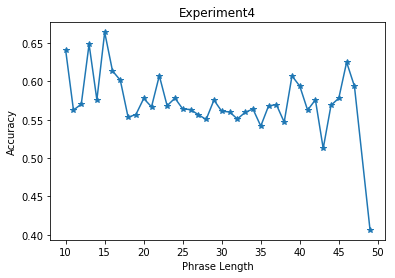

In [19]:
pic_name = 'Experiment4'
fig = plt.figure()
plt.plot(x,y,marker='*')
plt.title(pic_name)
plt.xlabel('Phrase Length')
plt.ylabel('Accuracy')
plt.show()
fig.savefig(pic_name+'.png',dpi = 100)